# AI Project - Music Genre Classification

### 1. Checking GPU Availability

In [28]:
# Enable GPU access and defining plotting functions
import torch
import librosa

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("Number of available GPUs:", device_count)
    for i in range(device_count):
        print("GPU", i, ":", torch.cuda.get_device_name(i))
else:
    print("GPU is not available")

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots()  # Create a single Axes object
    ax.plot(time_axis, waveform[0], linewidth=1)  # Plot the waveform
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

GPU is not available


### 2. Splitting Files into 5 Smaller Segments
To address the limited amount of data, we will split the original dataset into smaller segments. By dividing each 30-second audio file into five shorter segments, we increase the dataset’s size, enhancing its variability. This approach should improve the model’s training accuracy by providing more diverse training samples.


In [3]:
import torchaudio
import os

input_dir = "./Data/genres_original"
output_dir = "./Data_split/genres_original/"

def split_audio(audio_file, output_dir, num_segments=5, original_name=""):
    try:
        waveform, sample_rate = torchaudio.load(audio_file)
    except RuntimeError:
        print(f"Failed to load: {audio_file}")
        return

    total_duration = waveform.size(1) / sample_rate
    segment_duration = total_duration / num_segments
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_segments):
        start = int(i * segment_duration * sample_rate)
        end = int((i + 1) * segment_duration * sample_rate)

        if end > waveform.size(1):
            end = waveform.size(1)
        
        segment_waveform = waveform[:, start:end]

        segment_name = f"{original_name}_segment_{i + 1}.wav"
        output_file = os.path.join(output_dir, segment_name)
        
        torchaudio.save(output_file, segment_waveform, sample_rate)

# Function to split audio files and save segments
def split_audio_files(input_dir, output_dir, num_segments=5):
    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_dir, class_folder)
            os.makedirs(output_class_path, exist_ok=True)
            
            for audio_file in os.listdir(class_path):
                audio_file_path = os.path.join(class_path, audio_file)
                if os.path.isfile(audio_file_path):
                    # Split the audio file
                    split_audio(audio_file_path, output_class_path, num_segments, audio_file)

split_audio_files(input_dir, output_dir, num_segments=5)

Failed to load: ./Data/genres_original/jazz/jazz.00054.wav


### 3. Structure of the GTZAN Dataset

In [5]:
import os
import pandas as pd
GTZAN = output_dir
gtzan_directory_list = os.listdir(GTZAN)

file_genre = []
file_path = []

for folder in gtzan_directory_list:
    files_path = os.path.join(GTZAN, folder)
    for audio in os.listdir(files_path):
        file_genre.append(folder)
        file_path.append(files_path + "/" + audio)
genre_mapping = {genre: idx for idx, genre in enumerate(gtzan_directory_list)}
print(genre_mapping)

{'pop': 0, 'metal': 1, 'disco': 2, 'blues': 3, 'reggae': 4, 'classical': 5, 'rock': 6, 'hiphop': 7, 'country': 8, 'jazz': 9}


In [7]:
genre_df = pd.DataFrame(file_genre, columns=["Genre"])
path_df = pd.DataFrame(file_path, columns=["Path"])
gtzan_df = pd.concat([genre_df, path_df], axis=1)
gtzan_df.sample(n=10, random_state = 42)

,Genre,Path
84,pop,./Data_split/genres_original/pop/pop.00005.wav...
3036,rock,./Data_split/genres_original/rock/rock.00005.w...
1497,disco,./Data_split/genres_original/disco/disco.00035...
653,metal,./Data_split/genres_original/metal/metal.00009...
877,metal,./Data_split/genres_original/metal/metal.00048...
2897,classical,./Data_split/genres_original/classical/classic...
157,pop,./Data_split/genres_original/pop/pop.00080.wav...
3610,hiphop,./Data_split/genres_original/hiphop/hiphop.000...
751,metal,./Data_split/genres_original/metal/metal.00029...
3225,rock,./Data_split/genres_original/rock/rock.00084.w...


### 4. Utility Class for Audio Preprocessing
The class has the following methods:

* Opening a file as audio (waveform, sampling frequency)
* Changing the number of channels to the target (mono, 1 channel in this project, but the class is universal)
* Resampling to a given sampling frequency
* Adjusting the signal length; if it's too short, fill it with silence
* Creating a mel-scaled spectrogram

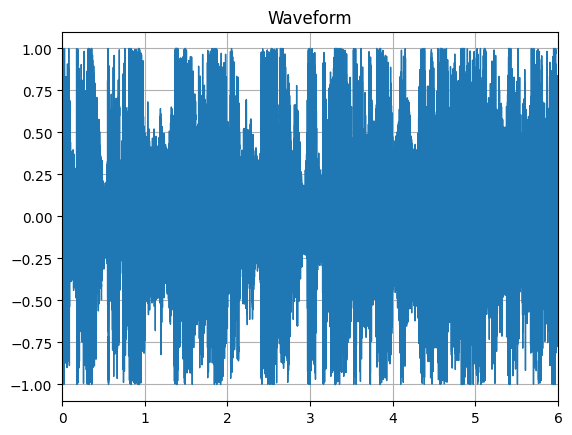

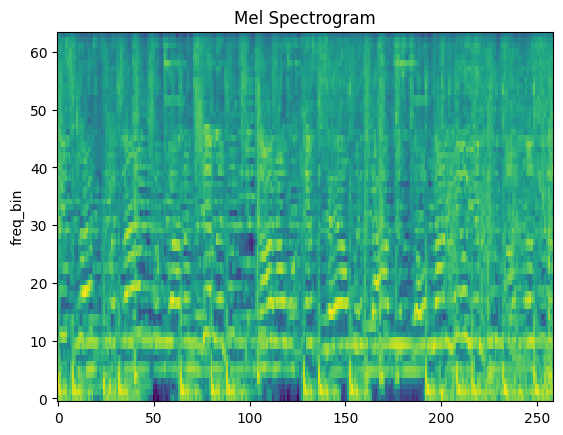

In [8]:
import math, random
import torch
import torchaudio

import matplotlib.pyplot as plt
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud
        if (sig.shape[0] == new_channel):
            return aud
        if (new_channel == 1):
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
            
        return ((resig, sr))
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud
        if (sr == newsr):
            return aud
        
        num_channels = sig.shape[0]
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return ((resig, newsr))
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
            
        return (sig, sr)
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
        
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return (spec)
    
aud = AudioUtil.open(gtzan_df.Path[75])
rechannel = AudioUtil.rechannel(aud, 1)
plot_waveform(rechannel[0], rechannel[1])
plot_spectrogram(AudioUtil.spectro_gram(rechannel)[0], title= "Mel Spectrogram")

### 5. Dataset train, val, test split for cross validation

In [9]:
import numpy as np
from torch import nn
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader
from glob import glob
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(gtzan_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

### 6. PyTorch Structure

In [23]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.class_names = sorted(dataframe['Genre'].unique())
        self.class_to_index = {class_name: i for i, class_name in enumerate(self.class_names)}
        self.file_list = [(row['Path'], self.class_to_index[row['Genre']]) for index, row in dataframe.iterrows()]
        self.transform = transform
        print(self.class_names)
        print(self.class_to_index)
        self.sr = 44100
        self.duration = 5500
        self.channel = 1
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        audio_file, class_id = self.file_list[idx]
        
        aud = AudioUtil.open(audio_file)
        resample = AudioUtil.resample(aud, self.sr)
        rechannel = AudioUtil.rechannel(resample, self.channel)
        equal_dur = AudioUtil.pad_trunc(rechannel, self.duration)
        melspectrogram = AudioUtil.spectro_gram(equal_dur)

        return melspectrogram, class_id
        
        
def create_data_loader(audio_folder, max_batch_size=16, shuffle=True):
    # Create AudioDataset
    audio_dataset = AudioDataset(audio_folder)
    
    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=max_batch_size, shuffle=shuffle)
    
    return data_loader

#### Create dataloaders and display class names.

In [24]:
class_names = gtzan_df['Genre'].unique()
print(class_names)

train_loader = create_data_loader(train_df)
val_loader = create_data_loader(val_df)
test_loader = create_data_loader(test_df)

['pop' 'metal' 'disco' 'blues' 'reggae' 'classical' 'rock' 'hiphop'
 'country' 'jazz']
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


### 7. CNN architecture

In [12]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.25)
        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with MaxPool
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        
        # Adaptive pooling to ensure fixed output dimensions
        x = self.adaptive_pool(x)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


model = SpectrogramCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 8. Training

Epoch [1/50], Training Loss: 1.8714, Validation Loss: 1.6546, Validation Accuracy: 47.00%


Epoch [2/50], Training Loss: 1.4476, Validation Loss: 1.3492, Validation Accuracy: 59.50%


Epoch [3/50], Training Loss: 1.2979, Validation Loss: 1.3531, Validation Accuracy: 54.00%


Epoch [4/50], Training Loss: 1.1978, Validation Loss: 1.2058, Validation Accuracy: 60.00%


Epoch [5/50], Training Loss: 1.1170, Validation Loss: 1.1237, Validation Accuracy: 59.75%


Epoch [6/50], Training Loss: 1.0655, Validation Loss: 1.0135, Validation Accuracy: 66.50%


Epoch [7/50], Training Loss: 1.0240, Validation Loss: 1.2361, Validation Accuracy: 58.25%


Epoch [8/50], Training Loss: 0.9701, Validation Loss: 1.0070, Validation Accuracy: 67.75%


Epoch [9/50], Training Loss: 0.9298, Validation Loss: 0.9505, Validation Accuracy: 69.50%


Epoch [10/50], Training Loss: 0.9105, Validation Loss: 0.9942, Validation Accuracy: 65.25%


Epoch [11/50], Training Loss: 0.8589, Validation Loss: 0.9345, Validation Accuracy: 71.25%


Epoch [12/50], Training Loss: 0.8436, Validation Loss: 0.9366, Validation Accuracy: 67.50%


Epoch [13/50], Training Loss: 0.7972, Validation Loss: 0.8668, Validation Accuracy: 71.25%


Epoch [14/50], Training Loss: 0.7969, Validation Loss: 0.8597, Validation Accuracy: 71.50%


Epoch [15/50], Training Loss: 0.7612, Validation Loss: 0.8641, Validation Accuracy: 70.00%


Epoch [16/50], Training Loss: 0.7325, Validation Loss: 0.9424, Validation Accuracy: 67.25%


Epoch [17/50], Training Loss: 0.7185, Validation Loss: 0.7970, Validation Accuracy: 73.75%


Epoch [18/50], Training Loss: 0.7028, Validation Loss: 0.8000, Validation Accuracy: 71.25%


Epoch [19/50], Training Loss: 0.6797, Validation Loss: 0.7956, Validation Accuracy: 73.75%


Epoch [20/50], Training Loss: 0.6660, Validation Loss: 0.8615, Validation Accuracy: 72.00%


Epoch [21/50], Training Loss: 0.6309, Validation Loss: 0.7862, Validation Accuracy: 73.50%


Epoch [22/50], Training Loss: 0.6294, Validation Loss: 0.8338, Validation Accuracy: 72.25%


Epoch [23/50], Training Loss: 0.6089, Validation Loss: 0.7127, Validation Accuracy: 75.00%


Epoch [24/50], Training Loss: 0.6007, Validation Loss: 0.8562, Validation Accuracy: 67.75%


Epoch [25/50], Training Loss: 0.5622, Validation Loss: 0.7597, Validation Accuracy: 71.75%


Epoch [26/50], Training Loss: 0.5636, Validation Loss: 0.7380, Validation Accuracy: 75.00%


Epoch [27/50], Training Loss: 0.5425, Validation Loss: 0.6758, Validation Accuracy: 76.00%


Epoch [28/50], Training Loss: 0.5389, Validation Loss: 0.6348, Validation Accuracy: 79.00%


Epoch [29/50], Training Loss: 0.5153, Validation Loss: 0.7118, Validation Accuracy: 75.00%


Epoch [30/50], Training Loss: 0.5085, Validation Loss: 0.6622, Validation Accuracy: 78.00%


Epoch [31/50], Training Loss: 0.4969, Validation Loss: 0.6381, Validation Accuracy: 79.00%


Epoch [32/50], Training Loss: 0.4631, Validation Loss: 0.6179, Validation Accuracy: 79.25%


Epoch [33/50], Training Loss: 0.4836, Validation Loss: 0.6563, Validation Accuracy: 79.00%


Epoch [34/50], Training Loss: 0.4549, Validation Loss: 0.6666, Validation Accuracy: 77.50%


Epoch [35/50], Training Loss: 0.4364, Validation Loss: 0.7002, Validation Accuracy: 76.25%


Epoch [36/50], Training Loss: 0.4256, Validation Loss: 0.6596, Validation Accuracy: 78.00%


Epoch [37/50], Training Loss: 0.4173, Validation Loss: 0.6269, Validation Accuracy: 79.75%


Epoch [38/50], Training Loss: 0.4236, Validation Loss: 0.6346, Validation Accuracy: 78.50%


Epoch [39/50], Training Loss: 0.4162, Validation Loss: 0.6146, Validation Accuracy: 79.25%


Epoch [40/50], Training Loss: 0.3957, Validation Loss: 0.6133, Validation Accuracy: 80.00%


Epoch [41/50], Training Loss: 0.3912, Validation Loss: 0.5588, Validation Accuracy: 81.75%


Epoch [42/50], Training Loss: 0.3836, Validation Loss: 0.5565, Validation Accuracy: 81.50%


Epoch [43/50], Training Loss: 0.3606, Validation Loss: 0.6039, Validation Accuracy: 81.00%


Epoch [44/50], Training Loss: 0.3591, Validation Loss: 0.6397, Validation Accuracy: 79.00%


Epoch [45/50], Training Loss: 0.3590, Validation Loss: 0.5493, Validation Accuracy: 82.25%


Epoch [46/50], Training Loss: 0.3356, Validation Loss: 0.5992, Validation Accuracy: 78.75%


Epoch [47/50], Training Loss: 0.3398, Validation Loss: 0.5807, Validation Accuracy: 80.75%


Epoch [48/50], Training Loss: 0.3316, Validation Loss: 0.6658, Validation Accuracy: 78.25%


Epoch [49/50], Training Loss: 0.3192, Validation Loss: 0.5083, Validation Accuracy: 83.25%


Epoch [50/50], Training Loss: 0.3232, Validation Loss: 0.5435, Validation Accuracy: 83.50%
Best validation accuracy: 83.50%


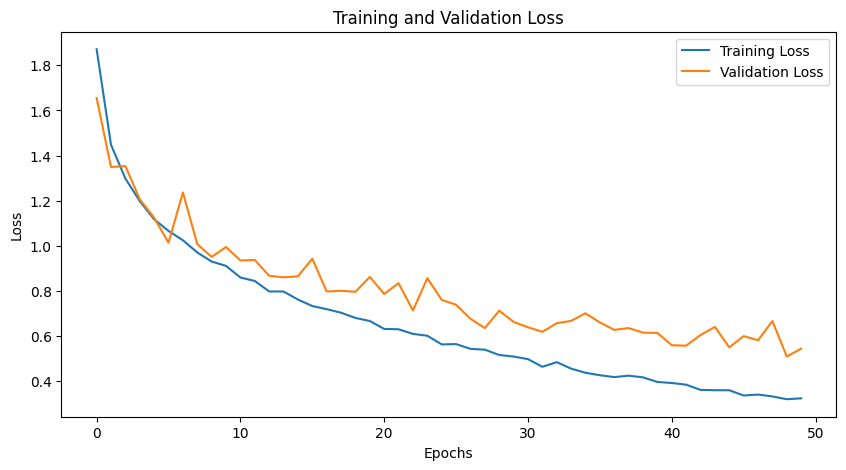

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Lists to store loss values for plotting
train_losses = []
val_losses = []

num_epochs = 50
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm to display progress
    train_iterator = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for batch_idx, (inputs, labels) in enumerate(train_iterator):
        inputs = inputs.float().to(device)  # Convert to float and move to device
        labels = labels.to(device)  # Move labels tensor to the device
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        train_iterator.set_postfix(loss=running_loss / ((batch_idx + 1) * train_loader.batch_size))  # Update progress bar
    
    # Calculate and store average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store average validation loss for the epoch
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Calculate validation accuracy
    val_accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'MGC_Model.pth')

print(f"Best validation accuracy: {best_accuracy:.2%}")

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### 9. Testing

/var/folders/99/nlz3h2917d11gd8t_nn_fj500000gn/T/ipykernel_33488/2977134233.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('MGC_Model.p

pop
metal
disco
blues
reggae
classical
rock
hiphop
country
jazz
Test Accuracy: 82.98%


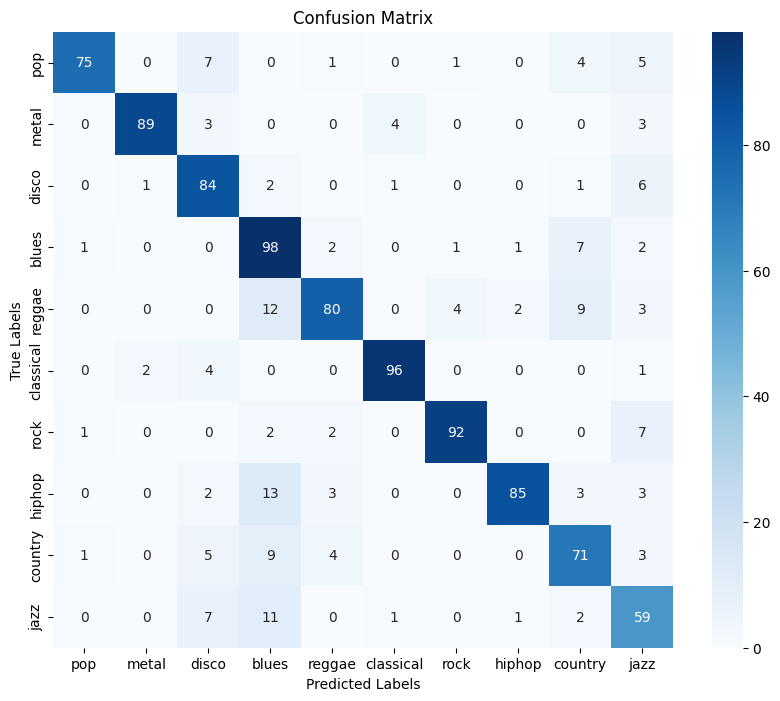

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('MGC_Model.pth'))
model = model.to(device)
model.eval()

# Test
correct_test = 0
total_test = 0
predicted_labels = []
true_labels = []
wrong_predictions = []

# for i = 0 to 10
for i in range(10):
    print(class_names[i])

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # Identify wrong predictions
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_predictions.append({
                    'Audio': inputs[i],  # Assuming inputs contain audio data
                    'True Label': labels[i].item(), 
                    'Predicted Label': predicted[i].item()
                })
# Calculate test accuracy
test_accuracy = correct_test / total_test

print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
## For testing a single audio file
from PIL import Image
model.eval()

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_file_path = "./data/genres_original/blues/blues.00002.wav"

audio, sr = AudioUtil.open(audio_file_path)

audio = AudioUtil.rechannel((audio, sr), 1)
audio = AudioUtil.resample(audio, 44100)
audio = AudioUtil.pad_trunc(audio, 5500)
spec = AudioUtil.spectro_gram(audio)
spec = spec.unsqueeze(0)  # Add batch dimension only

# Predict genre
with torch.no_grad():
    spec = spec.to(device)
    output = model(spec)
    _, predicted = torch.max(output, 1)
    genre_idx = predicted.item()
    print(genres[genre_idx])

blues
